# Inspect the FM 800K BB Extended Source MRS data  
In this notebook a spectral analysis of the 800K BB extended source MRS FM data is carried out. One analysis consists of checking the blackbody behavior of the straylight as opposed to the extended source spectrum itself.  
  
Notebook creation date: 15th of February 2018  
Author: Ioannis Argyriou (Institute of Astronomy, KUL)  
Email: ioannis.argyriou@kuleuven.be

## > Import modules

In [1]:
from distortionMaps import d2cMapping
import mrs_aux as maux
import funcs

import numpy as np
from astropy.io import fits
import scipy.interpolate as scp_interpolate
from matplotlib import pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

frame = (12,6) # figsize parameter dimensions for plotting

## > Get data

In [2]:
# Define paths to data
workDir    = "/Users/ioannisa/Desktop/python/miri_devel/"
cdpDir     = workDir+"cdp_data/"
lvl2_path  = workDir+"FM_data/LVL2/"

# Get data
bands = ['1A','1B','1C','2A','2B','2C','3A','3B','3C','4A','4B','4C']

# FM 800K BB extended source data files
sci_imgs = {"1A":lvl2_path +'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits',
            "1B":lvl2_path +'FM1T00011283/MIRFM1T00011283_1_495_SE_2011-05-31T03h12m30_LVL2.fits', 
            "1C":lvl2_path +'FM1T00011284/MIRFM1T00011284_1_495_SE_2011-05-31T04h09m25_LVL2.fits', 
            "2A":lvl2_path +'FM1T00011282/MIRFM1T00011282_1_495_SE_2011-05-31T02h15m32_LVL2.fits', 
            "2B":lvl2_path +'FM1T00011283/MIRFM1T00011283_1_495_SE_2011-05-31T03h12m30_LVL2.fits', 
            "2C":lvl2_path +'FM1T00011284/MIRFM1T00011284_1_495_SE_2011-05-31T04h09m25_LVL2.fits', 
            "3A":lvl2_path +'FM1T00011282/MIRFM1T00011282_1_494_SE_2011-05-31T02h15m02_LVL2.fits', 
            "3B":lvl2_path +'FM1T00011283/MIRFM1T00011283_1_494_SE_2011-05-31T03h11m59_LVL2.fits', 
            "3C":lvl2_path +'FM1T00011284/MIRFM1T00011284_1_494_SE_2011-05-31T04h08m55_LVL2.fits', 
            "4A":lvl2_path +'FM1T00011282/MIRFM1T00011282_1_494_SE_2011-05-31T02h15m02_LVL2.fits', 
            "4B":lvl2_path +'FM1T00011283/MIRFM1T00011283_1_494_SE_2011-05-31T03h11m59_LVL2.fits', 
            "4C":lvl2_path +'FM1T00011284/MIRFM1T00011284_1_494_SE_2011-05-31T04h08m55_LVL2.fits'}

bkg_imgs = {"1A":lvl2_path +'FM1T00011285/MIRFM1T00011285_1_495_SE_2011-05-31T05h06m47_LVL2.fits',
            "1B":lvl2_path +'FM1T00011286/MIRFM1T00011286_1_495_SE_2011-05-31T06h03m43_LVL2.fits', 
            "1C":lvl2_path +'FM1T00011287/MIRFM1T00011287_1_495_SE_2011-05-31T07h00m44_LVL2.fits', 
            "2A":lvl2_path +'FM1T00011285/MIRFM1T00011285_1_495_SE_2011-05-31T05h06m47_LVL2.fits', 
            "2B":lvl2_path +'FM1T00011286/MIRFM1T00011286_1_495_SE_2011-05-31T06h03m43_LVL2.fits', 
            "2C":lvl2_path +'FM1T00011287/MIRFM1T00011287_1_495_SE_2011-05-31T07h00m44_LVL2.fits', 
            "3A":lvl2_path +'FM1T00011285/MIRFM1T00011285_1_494_SE_2011-05-31T05h06m17_LVL2.fits', 
            "3B":lvl2_path +'FM1T00011286/MIRFM1T00011286_1_494_SE_2011-05-31T06h03m14_LVL2.fits', 
            "3C":lvl2_path +'FM1T00011287/MIRFM1T00011287_1_494_SE_2011-05-31T07h00m15_LVL2.fits', 
            "4A":lvl2_path +'FM1T00011285/MIRFM1T00011285_1_494_SE_2011-05-31T05h06m17_LVL2.fits', 
            "4B":lvl2_path +'FM1T00011286/MIRFM1T00011286_1_494_SE_2011-05-31T06h03m14_LVL2.fits', 
            "4C":lvl2_path +'FM1T00011287/MIRFM1T00011287_1_494_SE_2011-05-31T07h00m15_LVL2.fits'}

## > Transform data

In [3]:
# perform transform
wav,sci_signal,cal_sci_signal,straylight_curve = [{} for j in range(4)]
for band in bands:
    print 'Band {}'.format(band)
    # compute coordinate maps for spectral band
    d2cMaps = d2cMapping(band,cdpDir)
    # extract single maps
    sliceMap  = d2cMaps['sliceMap']
    alphaMap  = d2cMaps['alphaMap']
    betaMap   = d2cMaps['betaMap']
    lambdaMap = d2cMaps['lambdaMap']
    nslices   = maux.MRS_nslices[band[0]]
    mrs_fwhm  = maux.MRS_FWHM[band[0]]
    bzero     = d2cMaps['bzero']
    bdel      = d2cMaps['bdel']
    det_dims  = (1024,1032)
    
    # cpd files
    fringe_file,photom_file,psf_file,resol_file = funcs.get_cdps(cdpDir=cdpDir,band=band)

    fringe_img     = fits.open(fringe_file)[1].data        # [unitless]
    photom_img     = fits.open(photom_file)[1].data        # [DN/s * pixel/mJy]
    pixsiz_img     = fits.open(photom_file)[5].data        # [arcsec^2/pix]
    psffits        = fits.open(psf_file)                   # [unitless]
    specres_table  = fits.open(resol_file)[1].data         # [unitless]
    
    # observation
    sci_file = sci_imgs[band]
    bkg_file = bkg_imgs[band]
    
    sci_img = fits.open(sci_file)[0].data[0,:,:]
    bkg_img = fits.open(bkg_file)[0].data[0,:,:]
    cal_sci_img = sci_img-bkg_img
    
    # calibrate
#     #> straylight correction
#     cal_sci_img  = funcs.straylightCorrection(cal_sci_img,sliceMap)
#     straylight_img = (sci_img-bkg_img)-cal_sci_img
    
#     #> etc
    cal_sci_img /= fringe_img
    cal_sci_img /= photom_img
    cal_sci_img /= pixsiz_img
    
#     straylight_img /= photom_img
#     straylight_img /= pixsiz_img
    
    # trace is built by taking the pixel in every detector row with alpha value closest to the one specified
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=nslices/2,alpha_pos=0.)
    
    wav[band] = lambdaMap[ypos,xpos]
    sci_signal[band] = (sci_img-bkg_img)[ypos,xpos]
    cal_sci_signal[band] = cal_sci_img[ypos,xpos]
#     straylight_curve[band] = straylight_img[ypos,xpos]
    

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


## > Modeling

In [62]:
# experiment here
band = '1A'

d2cMaps = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
alphaMap  = d2cMaps['alphaMap']
lambdaMap  = d2cMaps['lambdaMap']
nslices   = maux.MRS_nslices[band[0]]
det_dims  = (1024,1032)

sci_img = fits.open(sci_imgs[band])[0].data[0,:,:]-fits.open(bkg_imgs[band])[0].data[0,:,:]
sci_img = funcs.OddEvenRowSignalCorrection(sci_img)
sci_img = funcs.straylightCorrection(sci_img,sliceMap)

ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=nslices/2,alpha_pos=0.)

In [63]:
# 2B: min_dist = 14
# 2C: min_dist = 18
# 3A: min_dist = 32
# 3B: min_dist = 39
# 3C: min_dist = 45
# 4A: min_dist = 50
# 4B: min_dist = 55
# 4C: min_dist = 75

<IPython.core.display.Javascript object>


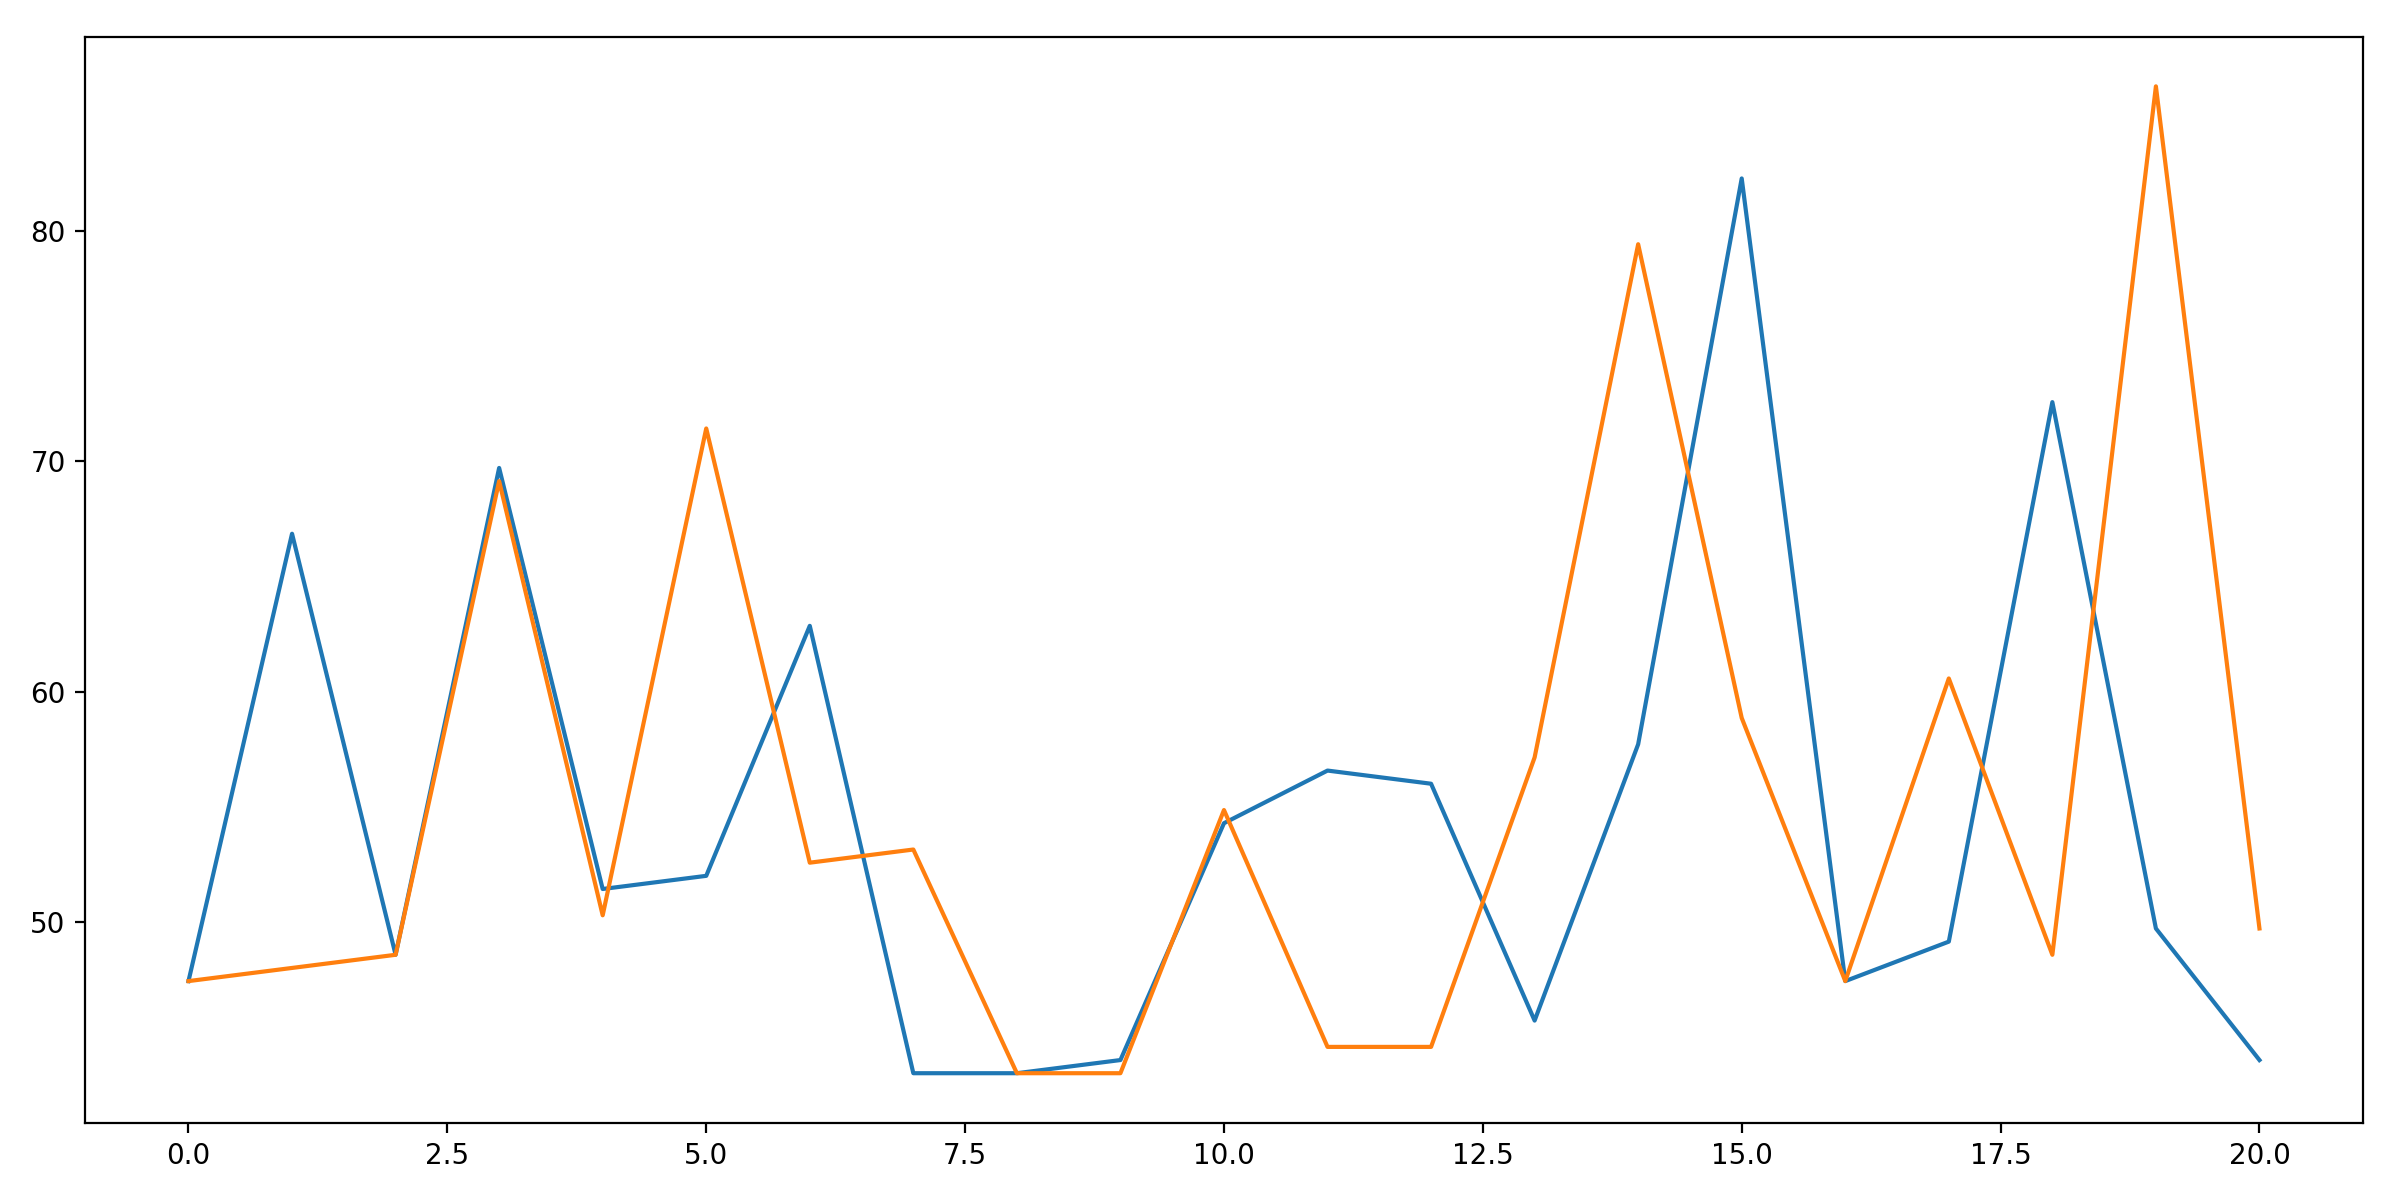

<IPython.core.display.Javascript object>


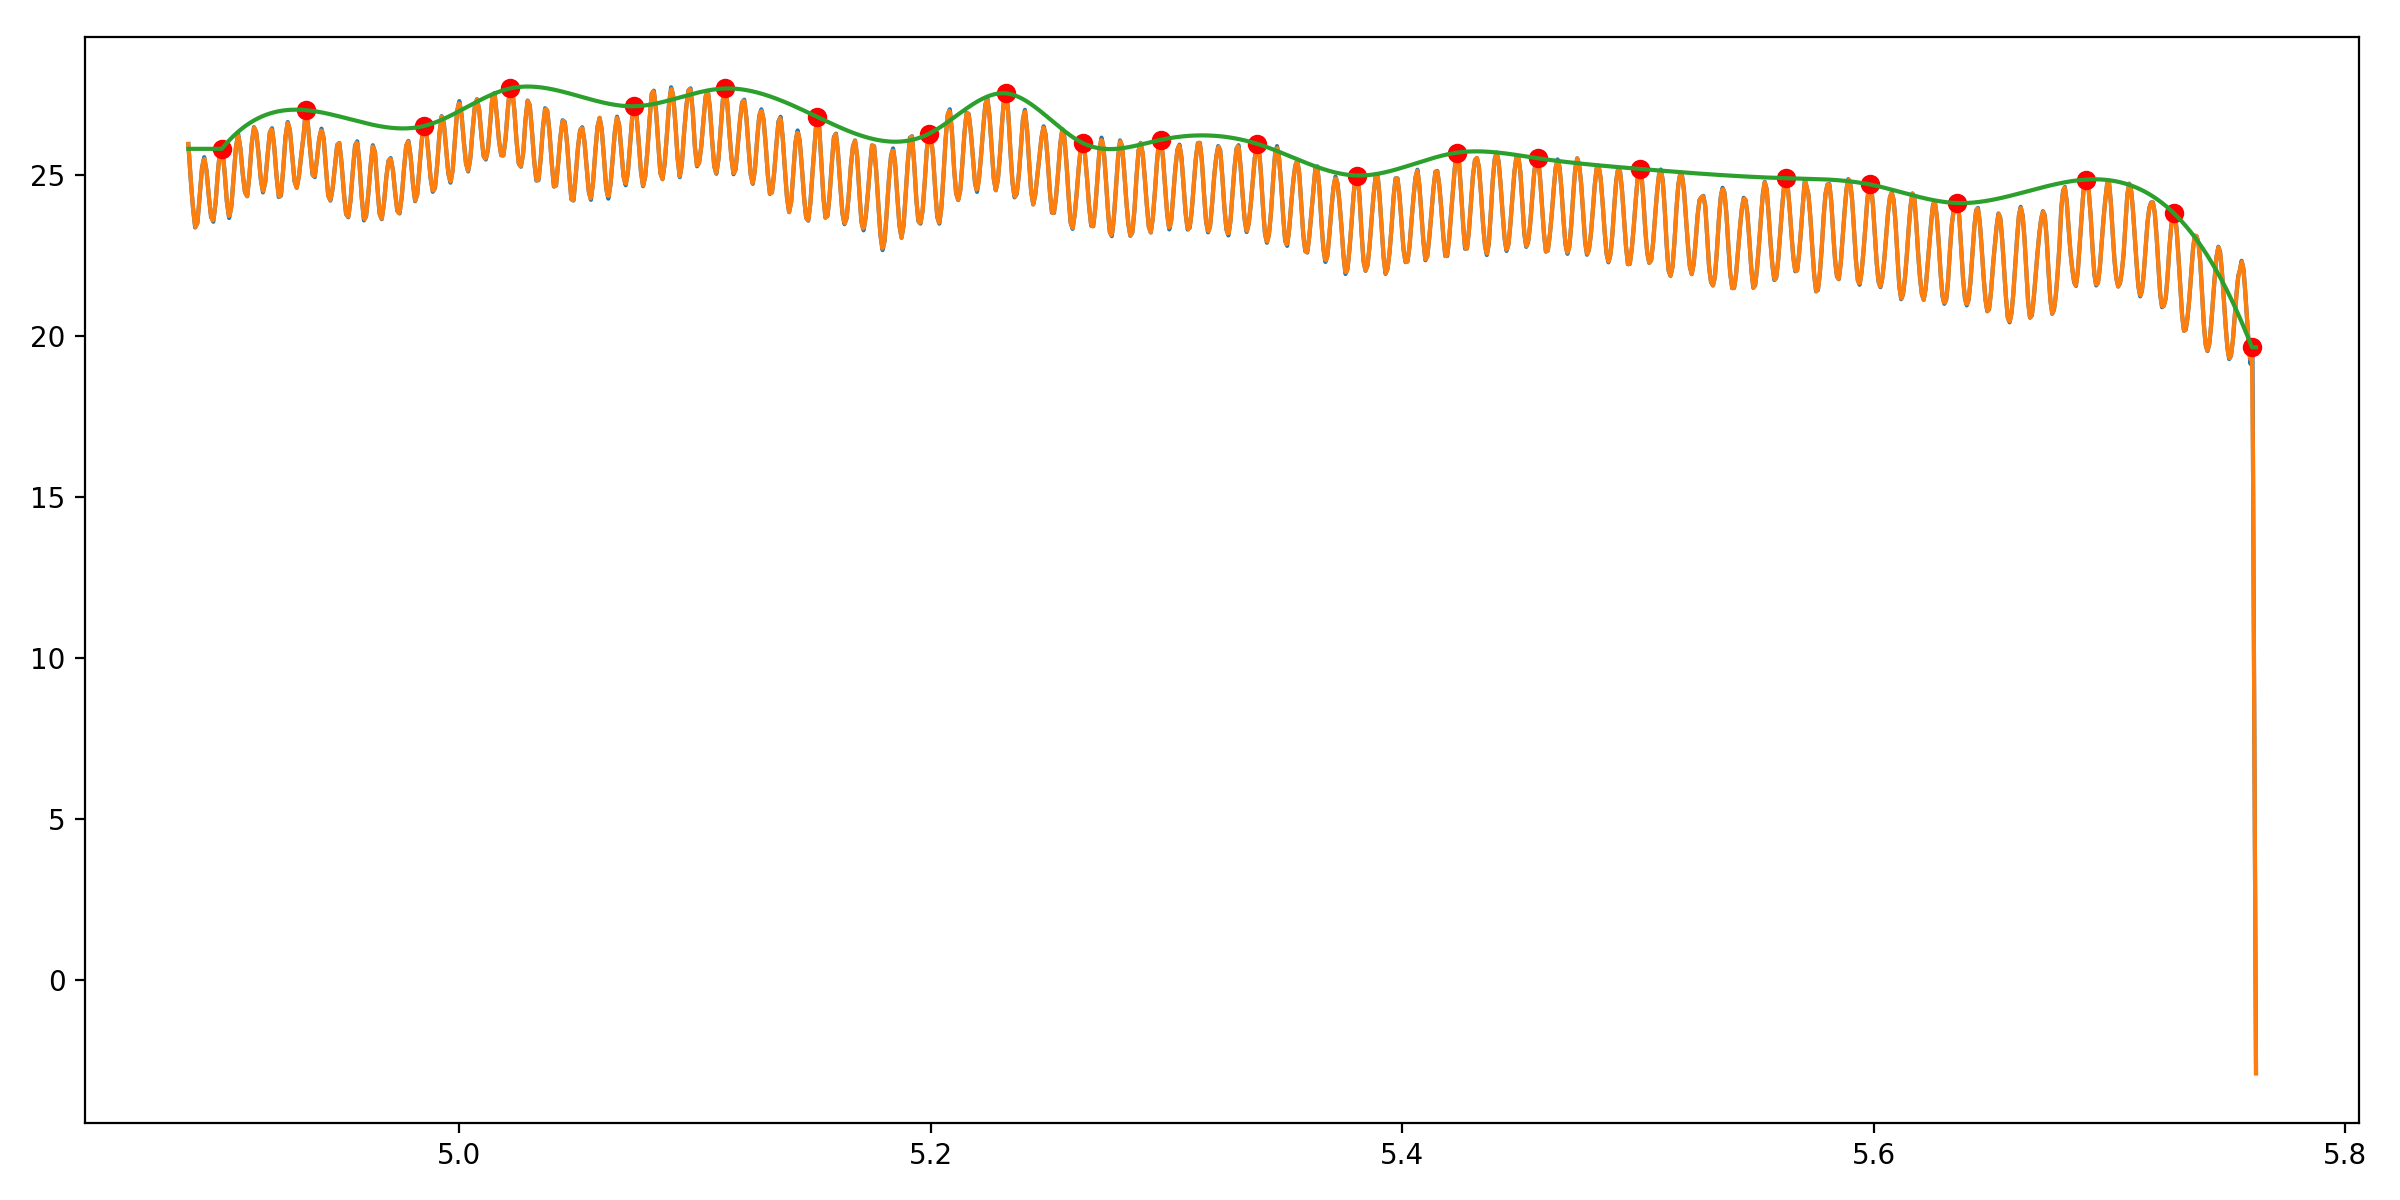

In [64]:
# determine peaks
# interpolate onto regular grid defined by wavelength
lambda_noNaN = lambdaMap[ypos,xpos][~np.isnan(lambdaMap[ypos,xpos])]
sci_img_noNaN = sci_img[ypos,xpos][~np.isnan(lambdaMap[ypos,xpos])]
lambda_noNaN = lambda_noNaN[~np.isnan(sci_img_noNaN)]
sci_img_noNaN = sci_img_noNaN[~np.isnan(sci_img_noNaN)]

interp_func = scp_interpolate.interp1d(lambda_noNaN,sci_img_noNaN)

lambmin,lambmax = lambda_noNaN.min(),lambda_noNaN.max()
new_lamb = np.linspace(lambmin,lambmax,2*len(lambda_noNaN))
interp_sci_img = interp_func(new_lamb)

peaks = funcs.find_peaks(interp_sci_img,thres=0.,min_dist=75)
peaksLO = funcs.find_peaks(-interp_sci_img,thres=0.,min_dist=75)
peaks = np.delete(peaks,np.where(np.abs(np.diff(np.diff(peaks)))>3*np.std(np.diff(np.diff(peaks))))[0]+2 )
# determine fringe continuum
arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks,interp_sci_img[peaks],k=3,ext=3)
sci_data_profile = arr_interpolator(range(len(interp_sci_img)))

plt.figure(figsize=(12,6))
plt.plot(np.diff(peaks)/1.75)
plt.plot(np.diff(peaksLO)/1.75)
# plt.plot(np.diff(np.diff(peaks)))
# plt.hlines(3*np.std(np.diff(np.diff(peaks))),0,105)
# plt.hlines(-3*np.std(np.diff(np.diff(peaks))),0,105)
plt.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(lambda_noNaN,sci_img_noNaN)
plt.plot(new_lamb,interp_sci_img)
plt.plot(new_lamb[peaks],interp_sci_img[peaks],'ro')
plt.plot(new_lamb,sci_data_profile)
plt.tight_layout()

In [70]:
# experiment here
all_peaksHI,all_peaksLO,new_lambdas,lamb_step,interpolated_sci_imgs,sci_img_profilesHI,sci_img_profilesLO = {},{},{},{},{},{},{}
for band in bands:
    print 'Band {}'.format(band)
    d2cMaps = d2cMapping(band,cdpDir)
    sliceMap  = d2cMaps['sliceMap']
    alphaMap  = d2cMaps['alphaMap']
    lambdaMap  = d2cMaps['lambdaMap']
    nslices   = maux.MRS_nslices[band[0]]
    det_dims  = (1024,1032)

    sci_img = fits.open(sci_imgs[band])[0].data[0,:,:]-fits.open(bkg_imgs[band])[0].data[0,:,:]
    sci_img = funcs.OddEvenRowSignalCorrection(sci_img)
    sci_img = funcs.straylightCorrection(sci_img,sliceMap)

    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=nslices/2,alpha_pos=0.)
    
    # determine peaks
    # interpolate onto regular grid defined by wavelength
    lambda_noNaN = lambdaMap[ypos,xpos][~np.isnan(lambdaMap[ypos,xpos])]
    sci_img_noNaN = sci_img[ypos,xpos][~np.isnan(lambdaMap[ypos,xpos])]
    lambda_noNaN = lambda_noNaN[~np.isnan(sci_img_noNaN)]
    sci_img_noNaN = sci_img_noNaN[~np.isnan(sci_img_noNaN)]

    interp_func = scp_interpolate.interp1d(lambda_noNaN,sci_img_noNaN)

    lambmin,lambmax = lambda_noNaN.min(),lambda_noNaN.max()
    new_lamb = np.linspace(lambmin,lambmax,2*len(lambda_noNaN))
    interp_sci_img = interp_func(new_lamb)
    
    if band in ['1A','1B','1C']: min_dist = 6
    elif band == '2A': min_dist = 8
    elif band == '2B': min_dist = 14
    elif band == '2C': min_dist = 18
    elif band == '3A': min_dist = 32
    elif band == '3B': min_dist = 39
    elif band == '3C': min_dist = 45
    elif band == '4A': min_dist = 50
    elif band == '4B': min_dist = 55
    elif band == '4C': min_dist = 75
    
    peaks = funcs.find_peaks(interp_sci_img,thres=0.,min_dist=min_dist)
    peaksLO = funcs.find_peaks(-interp_sci_img,thres=0.,min_dist=min_dist)
    peaks = np.delete(peaks,np.where(np.abs(np.diff(np.diff(peaks)))>3*np.std(np.diff(np.diff(peaks))))[0]+2 )
    # determine fringe continuum
    arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaks,interp_sci_img[peaks],k=3,ext=3)
    sci_data_profile = arr_interpolator(range(len(interp_sci_img)))
    
    arr_interpolator = scp_interpolate.InterpolatedUnivariateSpline(peaksLO,interp_sci_img[peaksLO],k=3,ext=3)
    sci_data_profileLO = arr_interpolator(range(len(interp_sci_img)))
    
    all_peaksHI[band] = peaks.copy()
    all_peaksLO[band] = peaksLO.copy()
    new_lambdas[band] = new_lamb.copy()
    lamb_step[band] = np.diff(new_lamb)[0]
    interpolated_sci_imgs[band] = interp_sci_img.copy()
    sci_img_profilesHI[band] = sci_data_profile.copy()
    sci_img_profilesLO[band] = sci_data_profileLO.copy()


Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


<IPython.core.display.Javascript object>


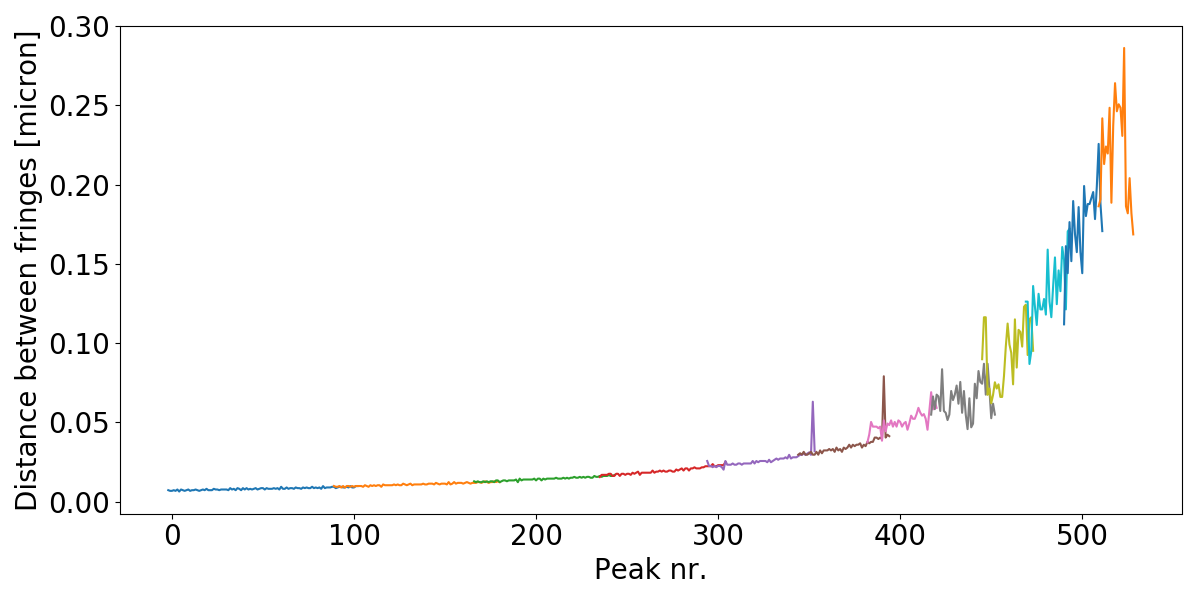

<IPython.core.display.Javascript object>


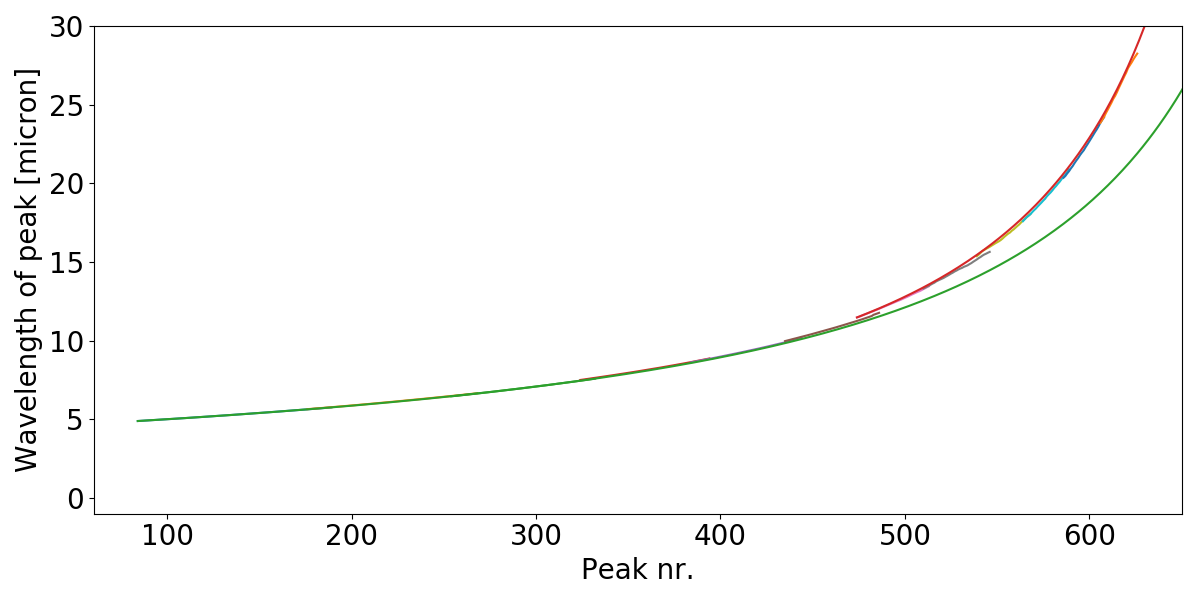

<IPython.core.display.Javascript object>


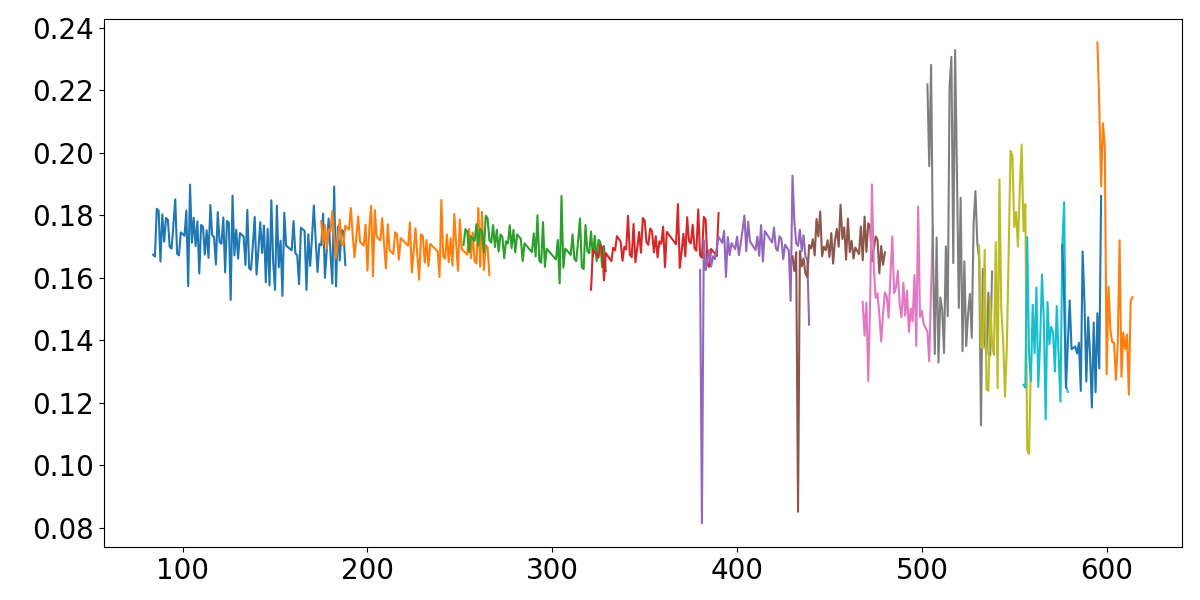

In [114]:
# make plots
plt.close('all')
plt.figure(figsize=frame)
counterHI = -len(all_peaksHI['1A'])
counterLO = -len(all_peaksLO['1A'])
for band in bands:
    counterHI += np.arange(len(all_peaksHI[band]))[:-1][-1]
    plt.plot(counterHI+np.arange(len(all_peaksHI[band]))[:-1],np.diff(all_peaksHI[band])*lamb_step[band])
#     counterLO += np.arange(len(all_peaksLO[band]))[:-1][-1]
#     plt.plot(counterLO+np.arange(len(all_peaksLO[band]))[:-1],np.diff(all_peaksLO[band])*lamb_step[band],'k')
plt.xlabel('Peak nr.',fontsize=20)
plt.ylabel('Distance between fringes [micron]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

arr = np.zeros(630)
arr[0] = 4.8919
for i in range(len(arr)-1):
    arr[i+1] = (3414.*arr[i]/(3414.-arr[i]))
    
arr2 = np.zeros(600)
arr2[0] = 11.4761 # 4.8919 # 
for i in range(len(arr2)-1):
    arr2[i+1] = (2900.*arr2[i]/(2900.-arr2[i]))

plt.figure(figsize=frame)
counterHI = -len(new_lambdas[band][all_peaksHI[band]])
for band in bands:
    counterHI += np.arange(len(new_lambdas[band][all_peaksHI[band]]))[-1]
    plt.plot(counterHI+np.arange(len(new_lambdas[band][all_peaksHI[band]])),new_lambdas[band][all_peaksHI[band]])
plt.plot(np.arange(len(arr))+84,arr)
plt.plot(np.arange(len(arr2))+474,arr2)
plt.xlim(60,650)
plt.ylim(-1,30)
plt.xlabel('Peak nr.',fontsize=20)
plt.ylabel('Wavelength of peak [micron]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

# plt.figure(figsize=frame)
# counterHI = -len(new_lambdas[band][all_peaksHI[band]])
# for band in bands:
#     counterHI += np.arange(len(new_lambdas[band][all_peaksHI[band]]))[-1]
#     plt.plot(counterHI+np.arange(len(new_lambdas[band][all_peaksHI[band]])),np.flipud(10000/new_lambdas[band][all_peaksHI[band]]) )
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()

plt.figure(figsize=frame)
counterHI = -len(new_lambdas[band][all_peaksHI[band]][:-1])
for band in bands:
    counterHI += np.arange(len(new_lambdas[band][all_peaksHI[band]]))[:-1][-1]
    plt.plot(counterHI+np.arange(len(new_lambdas[band][all_peaksHI[band]]))[:-1],0.5/np.diff(np.flipud(10000/new_lambdas[band][all_peaksHI[band]])) )
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

# plt.figure(figsize=frame)
# for band in bands:
#     plt.plot(new_lambdas[band],interpolated_sci_imgs[band])
#     plt.plot(new_lambdas[band],sci_img_profilesHI[band])
#     plt.plot(new_lambdas[band],sci_img_profilesLO[band])
# plt.xlabel('Wavelength [micron]',fontsize=20)
# plt.ylabel('Signal [DN/sec]',fontsize=20)
# plt.tick_params(axis='both',labelsize=20)
# plt.tight_layout()

## > Visualization

<IPython.core.display.Javascript object>


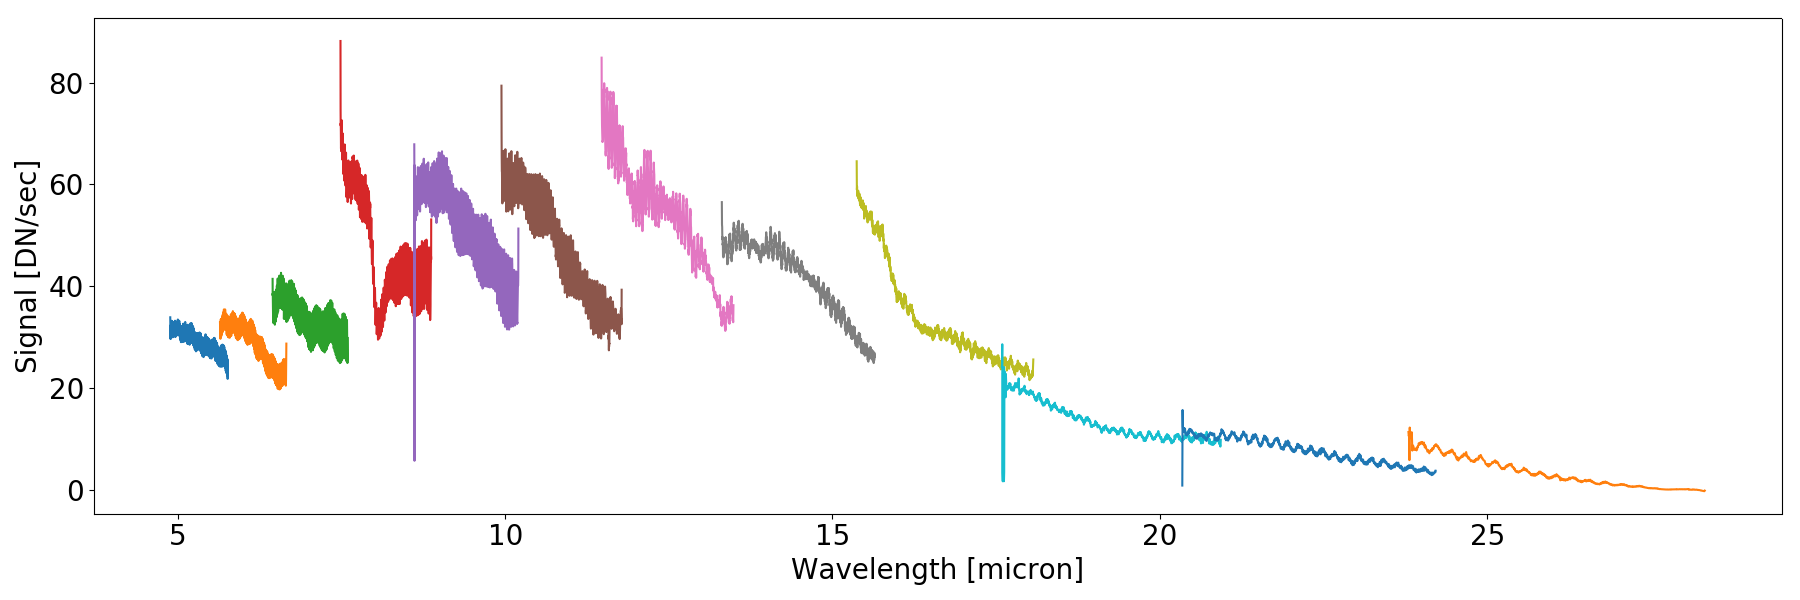

In [4]:
# make plots
plt.figure(figsize=(18,6))
for band in bands:
    plt.plot(wav[band],sci_signal[band])
#     plt.plot(wav[band],straylight_curve[band])
plt.xlabel('Wavelength [micron]',fontsize=20)
plt.ylabel('Signal [DN/sec]',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
plt.tight_layout()

## Summary:  
Insert summary here